# Travelling Salesman Problem (TSP) 

Talvez o mais famoso em otimização combinatória.

## Literatura

- Integer programming formulation of Traveling Salesman Problems. C. E. Miller, A. W. Tucker, R. A. Zemlin (1960)
- 


## Definição do Problema

Um viajante sai de uma cidade 1, e visita todas as outras cidades exatamente uma vez, retornando a cidade 1. O objetivo é minimizar os custos associados ao trajeto. Outras restrições podem ser adicionadas como por exemplo o limite de distância que o viajante pode percorrer por viagem e o número máximo de cidades que podem ser visitadas.


Focando o problema clássico, queremos minimizar a distância total percorrida, ou seja, minimizar a soma das distâncias entre as cidades visitadas.

## Modelagem

Cada cidade é representada por um nó em um grafo completo e cada aresta tem um custo associado. Em uma formulação de programação inteira, podemos definir variáveis binárias $x_{ij}$ que representam se o viajante vai diretamente da cidade $i$ para a cidade $j$. A soma dos custos das arestas representadas pelas variáveis $x_{ij}$ é o objetivo a ser minimizado.

$$

\text{Minimizar } \sum_{i=1}^{n} \sum_{j=1, j \neq i}^{n} c_{ij} x_{ij}

$$

Sujeito a:

1. Cada cidade deve ser visitada exatamente uma vez:

$$
\sum_{j=1, j \neq i}^{n} x_{ij} = 1 \quad \forall i = 1, 2, \ldots, n
$$

2. Cada cidade deve ser deixada exatamente uma vez:

$$
\sum_{i=1, i \neq j}^{n} x_{ij} = 1 \quad \forall j = 1, 2, \ldots, n
$$

3. Evitar ciclos menores que $n$ (subtours):

$$
u_i - u_j + n x_{ij} \leq n - 1 \
\quad \forall i, j = 2, 3, \ldots, n, i \neq j
$$

## Instância usada 

A instância é fornecida pelo eunciado do trabalho. Ela consiste em uma matriz de distâncias entre 250 cidades e uma matriz de tempos de viagem entre as mesmas cidades. Os dados fornecidos são duas matrizes 250x250, onde o elemento na linha i e coluna j representa a distância (ou tempo) entre a cidade i e a cidade j.

## Implementação

A implementação começa por ler os dados fornecidos, declarar as variáveis de decisão, escrever a função objetivo e a lista de restrições. Essa separação será útil na implementação de heurísticas posteriormente.


In [31]:
from pandas import read_csv
from numpy import array

class Problema:
    def __init__(self, distancias_file, tempos_file):
        self.distancias = array(read_csv(distancias_file, header=None))
        self.tempos = array(read_csv(tempos_file, header=None))
        self.n = self.distancias.shape[0]  # Número de cidades
        
    def funcao_objetivo(self, rota):
        distancia_total = 0
        tempo_total = 0
        for i in range(len(rota) - 1):
            distancia_total += self.distancias[rota[i], rota[i + 1]]
            tempo_total += self.tempos[rota[i], rota[i + 1]]
        # Adiciona o retorno à cidade inicial
        distancia_total += self.distancias[rota[-1], rota[0]]
        # Retorna uma tupla com distância total e tempo total
        return distancia_total, tempo_total
    def get_n(self):
        return self.n

def main():
    problema = Problema('distancia.csv', 'tempo.csv')
    rota_exemplo = range(1, problema.get_n())  # Exemplo de rota
    distancia, tempo = problema.funcao_objetivo(rota_exemplo)
    print(f'Distância total: {distancia}, Tempo total: {tempo}')
if __name__ == "__main__":
    main()


Distância total: 13374.500000000007, Tempo total: 267.69999999999993


A implementação acima usa a classe `Problema` para encapsular os dados e a função objetivo. A escolha das variáveis de decisão ficará a cargo de uma lista de cidades a serem visitadas (rota). A ordem dessas cidades na lista define a ordem de visitação e portanto as variáveis de decisão. Essa abordagem garante que cada cidade seja visitada exatamente uma vez e que o viajante retorne à cidade inicial. Além de garantir que não haja ciclos menores que n, já que a rota é uma lista linear que começa e termina na cidade inicial.

Na função `main` foi feita uma rota de exemplo que visita as cidades na ordem 0, 1, 2, ..., n-1 e retorna para a cidade 0. Essa rota é passada para a função objetivo que calcula a distância total e o tempo total da rota.

## Melhorando a função objetivo

Observando a disttribuição dos dados percebe-se que a relação entre distancia é quase
linear com o tempo. E que a média da razão distância/tempo é aproximadamente 50 vezes
maior que 1. Isso sugere que a função objetivo poderia ser uma combinação linear
das duas métricas, distância e tempo, com pesos apropriados.

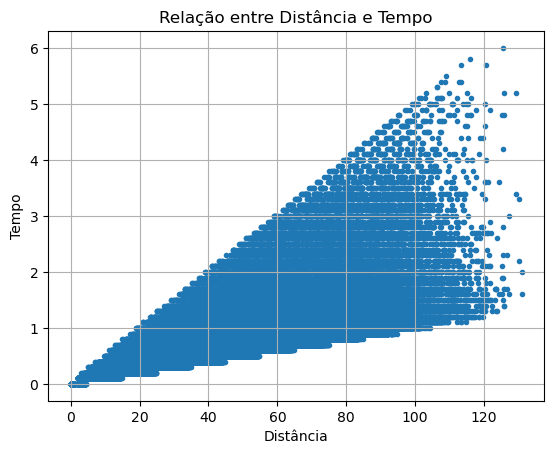

Média das Distâncias: 52.5171648
Média dos Tempos: 1.0553328
Relação Média Distância/Tempo: 49.76360518691356


In [32]:
import matplotlib.pyplot as plt

def enumerate_diferenca_tempo(distancias, tempos):
    plt.scatter(distancias, tempos, marker='.')
    plt.xlabel('Distância')
    plt.ylabel('Tempo')
    plt.title('Relação entre Distância e Tempo')
    plt.grid(True)
    plt.show()

problema = Problema('distancia.csv', 'tempo.csv')

enumerate_diferenca_tempo(problema.distancias.flatten(), problema.tempos.flatten())

media_distancia = problema.distancias.mean()
media_tempo = problema.tempos.mean()

print(f'Média das Distâncias: {media_distancia}')
print(f'Média dos Tempos: {media_tempo}')
print(f'Relação Média Distância/Tempo: {media_distancia/media_tempo}')
    

### Reescrevendo o problema mono-objetivo com normalização

Usando a estratégia de normalização min-max podemos reescrever o problema mono-objetivo como:

$$
d^n_{ij} = \frac{d_{ij} - D_{min}}{D_{max} - D_{min}} \\
t^n_{ij} = \frac{t_{ij} - T_{min}}{T_{max} - T_{min}}
$$

Quem seguida, a função objetivo pode ser expressa como:

$$

\text{Minimizar } \sum_{i=1}^{n} \sum_{j=1, j \neq i}^{n} \left( \alpha d^n_{ij} + (1 - \alpha) t^n_{ij} \right) x_{ij}
$$

Onde:
- $d^n_{ij}$ é a distância entre as cidades $i$ e $j$
- $d^n_{ij}$ é o tempo entre as cidades $i$ e $j$
- $D_{max}$ é a distância máxima possível (soma de todas as distâncias na matriz)
- $T_{max}$ é o tempo máximo possível (soma de todos os tempos na matriz)
- $\alpha$ é um parâmetro entre 0 e 1 que define a importância relativa de cada objetivo

In [33]:

class ProblemaMonoObjetivo(Problema):
    def __init__(self, distancias_file, tempos_file, alpha=0.5):
        super().__init__(distancias_file, tempos_file)
        self.alpha = alpha  # Peso para a distância
        self.beta = 1 - alpha  # Peso para o tempo
        self.normalizar() # Normaliza as matrizes de distância e tempo
    
    def normalizar(self):
        t_min = self.tempos.min()
        t_max = self.tempos.max()

        d_min = self.distancias.min()
        d_max = self.distancias.max()

        self.tempos = (self.tempos - t_min) / (t_max - t_min)
        self.distancias = (self.distancias - d_min) / (d_max - d_min)
        
    def funcao_objetivo(self, rota):
        distancia_total, tempo_total = super().funcao_objetivo(rota)
        return self.alpha * distancia_total + self.beta * tempo_total

Iteração 0, Melhor valor atual: 66.94623121976066
Iteração 100, Melhor valor atual: 48.11023045581874
Iteração 200, Melhor valor atual: 47.561382734912186
Iteração 300, Melhor valor atual: 47.436656480774175
Número máximo de iterações 400 atingido.
Melhor rota: [168, 213, 137, 55, 222, 57, 228, 110, 133, 59, 192, 81, 119, 185, 207, 121, 234, 216, 138, 79, 20, 1, 11, 179, 53, 223, 191, 139, 149, 111, 147, 136, 58, 215, 97, 113, 95, 99, 107, 244, 177, 41, 115, 249, 209, 39, 226, 62, 120, 70, 232, 132, 154, 123, 64, 56, 89, 184, 175, 46, 176, 14, 32, 211, 206, 194, 160, 186, 48, 148, 104, 195, 5, 231, 189, 245, 7, 182, 131, 128, 12, 17, 49, 28, 109, 77, 37, 173, 221, 18, 108, 156, 183, 92, 3, 30, 152, 75, 42, 229, 178, 71, 242, 44, 72, 165, 2, 174, 78, 243, 15, 114, 23, 237, 63, 210, 100, 218, 122, 96, 164, 248, 240, 143, 162, 61, 84, 16, 24, 106, 202, 198, 208, 0, 146, 247, 129, 144, 220, 67, 45, 33, 169, 27, 193, 225, 188, 167, 246, 19, 102, 21, 74, 93, 239, 94, 238, 126, 43, 101, 141, 

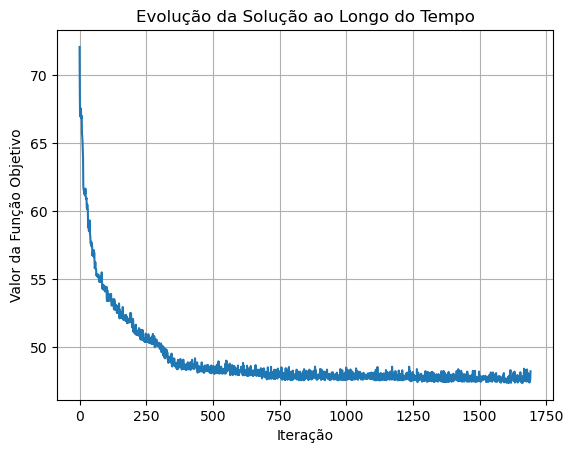

In [39]:
import random
from time import time

class TSP_GVNSSolver:
    def __init__(self, problema, initial_solution=None):
        self.problema = problema
        self.solutions_buffer = []
        if initial_solution is None:
            self.current_solution = list(range(self.problema.get_n()))
            random.shuffle(self.current_solution)
    
    def ns_swap(self, rota):
        # Troca dois elementos na rota
        nova_rota = rota[:]
        #numero aleatorio entre 1 e n-1
        r = random.randint(1, len(rota)-2)
        i, j = r, r + 1  # Exemplo fixo, pode ser aleatório
        nova_rota[i], nova_rota[j] = nova_rota[j], nova_rota[i]
        return nova_rota
    
    def ns_2opt(self, rota):
        # Inverte uma subsequência na rota
        nova_rota = rota[:]
        r = random.randint(1, len(rota)-3)
        i, j = r, r + 2  # Exemplo fixo, pode ser aleatório
        nova_rota[i:j] = reversed(nova_rota[i:j])
        return nova_rota
    
    def ns_insercao(self, rota):
        # Remove um elemento e o insere em outra posição
        nova_rota = rota[:]
        r = random.randint(1, len(rota)-1)
        i, j = r, (r + 2) % len(rota)  # Exemplo fixo, pode ser aleatório
        elem = nova_rota.pop(i)
        nova_rota.insert(j, elem)
        return nova_rota
    
    def ns_swap3(self, rota):
        # Troca três elementos na rota
        nova_rota = rota[:]
        r = random.randint(1, len(rota)-3)
        i, j, k = r, r + 1, r + 2  # Exemplo fixo, pode ser aleatório
        nova_rota[i], nova_rota[j], nova_rota[k] = nova_rota[k], nova_rota[i], nova_rota[j]
        return nova_rota
    
    def ns_reiniciar(self):
        # Gera uma nova rota aleatória 
        # TODO: Avaliar se essa é uma boa estratégia
        nova_rota = list(range(self.problema.get_n()))
        random.shuffle(nova_rota)
        return nova_rota
    
    def ns_vizinhanca(self, rota, k):
        if k == 0:
            return self.ns_swap(rota)
        elif k == 1:
            return self.ns_2opt(rota)
        elif k == 2:
            return self.ns_insercao(rota)
        elif k == 3:
            return self.ns_swap3(rota)
        else:
            raise ValueError("k inválido")

    def best_improvement(self, rota):
        melhor_rota = rota
        melhor_valor = self.problema.funcao_objetivo(rota)
        melhorado = True
        
        while melhorado:
            melhorado = False
            for k in range(4):  # Número de vizinhanças
                nova_rota = self.ns_vizinhanca(melhor_rota, k)
                novo_valor = self.problema.funcao_objetivo(nova_rota)
                if novo_valor < melhor_valor:
                    melhor_rota = nova_rota
                    melhor_valor = novo_valor
                    melhorado = True
                    break  # Sai do for para reiniciar a busca
        
        return melhor_rota, melhor_valor
    
    def first_improvement(self, rota):
        melhor_rota = rota
        melhor_valor = self.problema.funcao_objetivo(rota)
        
        for k in range(4):  # Número de vizinhanças
            nova_rota = self.ns_vizinhanca(melhor_rota, k)
            novo_valor = self.problema.funcao_objetivo(nova_rota)
            if novo_valor < melhor_valor:
                return nova_rota, novo_valor  # Retorna na primeira melhoria
        
        return melhor_rota, melhor_valor  # Nenhuma melhoria encontrada

    def vns_basico(self, max_iter=100, max_t=1000):
        t_start = time()
        for i in range(max_iter):
            k = 0
            while k < 4:
                # recreated_solution = self.ns_reiniciar()
                self.current_solution, current_value = self.best_improvement(self.current_solution)
                nova_solucao = self.ns_vizinhanca(self.current_solution, k)
                novo_valor = self.problema.funcao_objetivo(nova_solucao)

                ## Para análise posterior
                self.solutions_buffer.append(novo_valor)

                if novo_valor < current_value:
                    self.current_solution = nova_solucao
                    k = 0  # Reinicia a busca na primeira vizinhança
                else:
                    k += 1  # Avança para a próxima vizinhança
            if time() - t_start > max_t:
                print(f'Tempo máximo de {max_t} segundos atingido.')
                break
            if i % 100 == 0:
                print(f'Iteração {i}, Melhor valor atual: {current_value}')
            if i == max_iter - 1:
                print(f'Número máximo de iterações {max_iter} atingido.')
        return self.current_solution, self.problema.funcao_objetivo(self.current_solution)
    
    def plot_solutions_buffer(self):
        valores = [val for val in self.solutions_buffer]
        print(f'Número de soluções armazenadas: {len(valores)}')
        plt.plot(valores)
        plt.xlabel('Iteração')
        plt.ylabel('Valor da Função Objetivo')
        plt.title('Evolução da Solução ao Longo do Tempo')
        plt.grid(True)
        plt.show()


solver = TSP_GVNSSolver(problema_mono)
melhor_rota, melhor_valor = solver.vns_basico(max_iter=400, max_t=10)
print(f'Melhor rota: {melhor_rota}')
print(f'Melhor valor da função objetivo: {melhor_valor}')
solver.plot_solutions_buffer()